# Baseline model: Random Walk

## Based on the article [Timo van Niedek & Arjen P. de Vries](https://dl.acm.org/doi/pdf/10.1145/3267471.3267483)

The ideia is to represent the playlist dataset as a bipartite graph. We use multiple random walks over it. The playlist title are used for prefiltering and ranking titles. This is the simplest way to use similarity between tracks. 

In [1]:
# Importing libraries 
import pandas as pd 
import numpy as np 

from scipy.sparse import lil_matrix
from sklearn.model_selection import train_test_split
from multiprocessing import Pool

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import glob
import os

## Playlist and Tracks Dataframes 

Here we get the playlists and the tracks. I get playlists with at least 5 tracks and at minimum 500 tracks, because it's uncommon out of these bounds. We will get only a small part of the users (200) because this is a baseline model, it's pretty simple and it's not optimezed. 

In [2]:
# Users Sample
sample = 100   
playlists_df = pd.read_pickle('../../data/sp_playlists.pkl')[['owner_id', 'id', 'tracks']]
# Reproducibility
seed = np.random.RandomState(100)  
chosen_users = seed.choice(playlists_df.owner_id.unique(), size = sample, replace = False)
playlists_df = playlists_df[playlists_df.owner_id.isin(chosen_users)]
playlists_df.rename(columns = {'id': 'playlist_id', 'tracks': 'n_tracks'}, inplace = True)

playlists_df.n_tracks = playlists_df.n_tracks.apply(lambda x: x['total'])

# Getting Playlists with at least 5 tracks and maximum of 500 tracks
playlists_df = playlists_df[(playlists_df.n_tracks >= 5) & (playlists_df.n_tracks <= 500)]

del playlists_df['n_tracks']
del playlists_df['owner_id']

In [3]:
tracks_df = pd.DataFrame()
for file in tqdm(glob.glob('../../data/sp_tracks_ready_*.pkl')):
    a = pd.read_pickle(file)[['id', 'playlist_id', 'artists_ids']]
    a = a[a.playlist_id.isin(playlists_df.playlist_id)]
    tracks_df = pd.concat([tracks_df, a], ignore_index = True)

del playlists_df
del a

It will make easier to work with union and intersection in the accuracy metric. 

In [4]:
tracks_df = tracks_df[~tracks_df.artists_ids.isnull()] 
tracks_df['artists_ids'] = tracks_df.artists_ids.apply(set)

## Model

### Bipartite Graph

We build a Bipartite Graph, through a sparse matrix, where the lines are the playlists (like groups) and the columns are the tracks. If the track is in the playlist, we mark 1. 

### Random Walk

Starting with a playlist, or a sequence of tracks, we can obtain a completation using a random walk with restart. For each song we walk in the graph and count the tracks we passed through. We get the tracks with high counts. The parameter $N_q = N/|P|$ is how many walks we will give, except by a parameter $\alpha$, the probability of restart. 

In [5]:
class RandomWalkPlaylists:
    
    def __init__(self, tracks: pd.DataFrame, playlists: pd.DataFrame): 
        '''Implementation of the Simmilarity Model described above. 
           The metric used are describe in PATS article. 
           - tracks: all the tracks in your world. 
           - playlists: the training playlists.
        '''
        
        self.tracks = tracks
        self.tracks_index = self.tracks[['id']].drop_duplicates('id').reset_index()
        self.playlists = playlists.drop_duplicates().reset_index()

    def fit(self): 

        self.graph = self._build_graph()

    def _get_index(self, objects_ids, t_or_p):
        if t_or_p == 't': 
            indexes = self.tracks_index[self.tracks_index.id.isin(objects_ids)].index
        elif t_or_p == 'p':
            indexes = self.playlists[self.playlists.playlist_id.isin(objects_ids)].index
        return list(indexes)
    
    def _get_object_id(self, index, t_or_p):
        if t_or_p == 't': 
            object_id = self.tracks_index.loc[index]
        elif t_or_p == 'p':
            object_id = self.playlists.loc[index]
        return object_id.id
    
    def _build_graph(self): 
        
        T = len(self.tracks_index)
        P = len(self.playlists)
        
        graph = lil_matrix((P, T), dtype = int)
        
        for playlist_id in tqdm(self.playlists.playlist_id): 
            playlist_index = self._get_index({playlist_id}, 'p')
            tracks_ids = self.tracks[self.tracks.playlist_id == playlist_id].id
            indexes = self._get_index(tracks_ids, 't')
            
            graph[playlist_index, indexes] = -1
        
        return graph
    
    def _random_playlist(self, graph, track_index): 
        
        # We have a one column matrix. I get the lines(playlists)
        nonzerolines = graph[:,track_index].nonzero()[0]
        if len(nonzerolines) == 0: 
            return None
        return np.random.choice(nonzerolines)
    
    def _random_track(self, graph, playlist_index): 
        
        # We have a one line matrix. I get the columns (tracks)
        nonzerocolumns = graph[playlist_index,:].nonzero()[1]
        if len(nonzerocolumns) == 0:
            return None
        return np.random.choice(nonzerocolumns)
            
    def _simple_random_walk(self, graph, track, alpha: float, Nq: int): 
        '''Function to wandom walk given a track.'''
        n = 0
        # counting set
        V = {}       
        while n < Nq: 
            t_curr = track
            n_curr = 0
            N_curr = np.random.geometric(alpha)
            while n_curr < N_curr or n + n_curr < Nq:
                p_curr = self._random_playlist(graph, t_curr)
                n_curr += 1
                if not p_curr:
                    continue
                t_curr = self._random_track(graph, p_curr)
                if not t_curr: 
                    continue
                if t_curr in V:  
                    V[t_curr] += 1
                else:
                    V[t_curr] = 1
            n += n_curr
        return V
            
    def multiple_random_walks(self, graph, playlist_not_hidden, alpha: float, N: int):
        '''Function to do random walk for every track. 
            - alpha: probabilitity of restart again in the search. 
            - N: maximum number of operations. 
        '''
        query_tracks = self._get_index(playlist_not_hidden.id, 't')
        n = len(query_tracks)
        if n == 0:
            return None
        Nq = N/n
        V = {}
        for track in query_tracks:
            Vq = self._simple_random_walk(graph, track, alpha, Nq)
            V.update(Vq)
            
        return V

    def predict(self, playlist_not_hidden, alpha: float, N: int, number_of_tracks): 

        V = self.multiple_random_walks(self.graph, playlist_not_hidden, alpha, N)
        if V is None:
            return None
        chosen = sorted(V.items(), key = lambda x: x[1], reverse = True)[0:number_of_tracks]
        chosen = [c[0] for c in chosen]
        chosen_tracks = self._get_object_id(chosen, 't')
        return self.tracks[self.tracks.id.isin(chosen_tracks)].drop_duplicates('id')

    def accuracy_metric(self, predicted, true, n, j):

        G_a = set() 
        for artist_id in predicted.artists_ids:
            G_a = G_a.union(artist_id)

        S_a = set()
        for artist_id in true.artists_ids:
            S_a = S_a.union(artist_id)

        ytrue = set(true.id)
        yhat = set(predicted.id)

        acc = (len(ytrue & yhat) + 0.25*len(S_a & G_a))/(n - j)
        return acc
    
    def evaluate_model(self, playlists_test, alpha: float, N: int, rate: 0.7): 

        accuracy = []

        for playlist_id in tqdm(playlists_test): 

            playlist = self.tracks[self.tracks.playlist_id == playlist_id]
            n = len(playlist)
            if n <= 5:
                continue
            playlist_not_hidden = playlist.iloc[0: int(n*rate)]
            playlist_hidden = playlist.iloc[int(n*rate):]

            predicted = self.predict(playlist_not_hidden, alpha, N, n - int(n*rate))
            acc = self.accuracy_metric(predicted, playlist_hidden, n, int(n*rate))
            accuracy.append(acc)
        
        return np.mean(accuracy)

## Evaluation 

### R-precision metric

As described in their work, [Chen et al.](https://dl.acm.org/doi/10.1145/3240323.3240342) suggests a metric for playlist continuation evaluation. They call it **R-precision**. It measures how many of the real tracks (and their artists) the model suggested correctly.

A playlist as input to the model has two parts: its part on display to the model and it's hidden part. The hidden part is what the model try to predict and is called *ground truth*.

$$\textrm{R-precision} = \dfrac{|S_T \cap G_T| + 0.25 \cdot |S_A \cap G_A|}{|G_T|}$$

$G_T$ is the set of unique track IDs from ground truth, that is, the unique hidden tracks. $S_T$ is the suggested tracks from our model. $G_A$ is the set of unique artists IDs from ground truth and $S_A$ is the set of predicted artists. The metric can be interpreted as accuracy (although it can be greater than 1), but giving some score for wrong tracks with right artists.

```
def accuracy_metric(predicted, true, n, j):

    G_a = set() 
    for artist_id in predicted.artists_ids:
        G_a = G_a.union(artist_id)

    S_a = set()
    for artist_id in true.artists_ids:
        S_a = S_a.union(artist_id)

    ytrue = set(true.id)
    yhat = set(predicted.id)

    acc = (len(ytrue & yhat) - j + 0.25*len(S_a & G_a))/(n - j)
    return acc
``` 

## Training the model

First, I will get `playlist_id` for train and test. I drop the duplicates cause I'm not interested in playlists with repeated tracks. We will use only a small subset because it's a simple model without optimizations. 

In [6]:
tracks_subset = tracks_df.drop_duplicates(['id', 'playlist_id'])
playlists = tracks_subset.drop_duplicates('playlist_id').playlist_id
tracks_subset = tracks_subset[tracks_subset.playlist_id.isin(playlists)]
tv, test = train_test_split(playlists, random_state = 100)
train, validate = train_test_split(tv, random_state = 200)

In [7]:
model = RandomWalkPlaylists(tracks_subset, train) 
model.fit()

## Using the parameter $\alpha$. 

Depending the chosen $N$, the time grows exponencially! I will keep it 1000 because low it performs worst and more than that, the computation is pretty expensive. 

In [8]:
alphas = [0.5, 0.6, 0.7, 0.8, 0.9]

parameters = [[validate, alpha, 1000, 0.7] for alpha in alphas]

with Pool(4) as pool:
    evaluation = pool.starmap(model.evaluate_model, parameters)

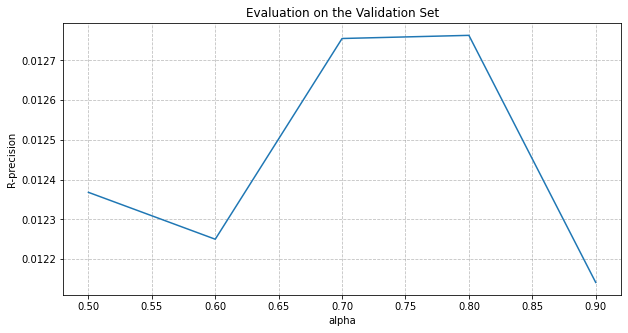

In [9]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(alphas, evaluation)
ax.set_title('Evaluation on the Validation Set')
ax.set_ylabel('R-precision')
ax.set_xlabel('alpha')
plt.grid(alpha = 0.5, color = 'grey', linestyle = '--')
plt.show()

### Varying the ratio parameter

The ratio parameter indicates how much of the playlist we know before.

In [10]:
alpha_best = alphas[np.argmax(evaluation)]

In [8]:
model_best = RandomWalkPlaylists(tracks_subset, tv) 

In [9]:
model_best.fit()

In [11]:
ratios = [0.4, 0.6, 0.8, 0.9]

parameters = [[test, alpha_best, 1000, ratio] for ratio in ratios]

with Pool(4) as pool:
    evaluation = pool.starmap(model_best.evaluate_model, parameters)

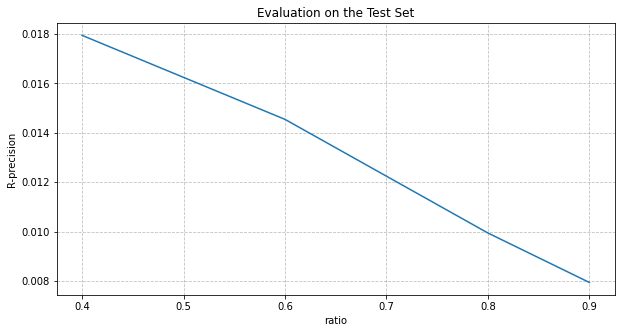

In [12]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(ratios, evaluation)
ax.set_title('Evaluation on the Test Set')
ax.set_ylabel('R-precision')
ax.set_xlabel('ratio')
plt.grid(alpha = 0.5, color = 'grey', linestyle = '--')
plt.show()